## Imports

In [1]:
%matplotlib inline

import numpy as np
import cvxpy as cvx
import gurobipy as grb
import scipy.io as sio

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

** Problem 1. ** *Censored data fitting* (2 points). 

### Solution

Our goal is to find the model parameter $c$ and $y^{(M+1)},\dots,y^{(K)}$ that minimize the following functional:

$$
J = \sum_{i=1}^K (y^{(k)} - c^Tx^{(k)})^2 = \|Y - X^T c\|_2^2
$$

Including given constraints we can reformulate this problem as constrained linear least squares problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{Y,c}{\text{minimize}}
& & \|Y - X^T c\|_2 \\
& \text{subject to}
& & Y_i = y^{(i)}, \; i = 1, \ldots, M, \\
&&& Y_j \geq D, \; j = M+1, \dots, K.
\end{aligned}
\end{equation*}
$$

In [2]:
def censored_data_fitting(mat_contents):
    """Solve fitting problem with censored data."""
    
    # parse data
    D = mat_contents['D'][0, 0] 
    M = mat_contents['M'][0, 0] 
    X = mat_contents['X'] 
    c_true = mat_contents['c_true'][:, 0] 
    y = mat_contents['y'][:, 0]
    K = X.shape[1]
    n = X.shape[0]

    # formulate and solve optimization problem with censored data
    Y = cvx.Variable(K)
    c1 = cvx.Variable(n)

    constraints1 = [Y[:M] == y, Y[M:K] >= D]
    objective1 = cvx.Minimize(cvx.sum_entries(cvx.square(Y - X.T*c1)))    
    prob1 = cvx.Problem(objective1, constraints1)
    
    sol1 = prob1.solve()
    eps1 = np.linalg.norm(c_true - np.array(c1.value).reshape(-1)) / np.linalg.norm(c_true)
    
    # formulate and solve optimization problem without censored data
    c2 = cvx.Variable(n)
    
    constraints2 = []
    objective2 = cvx.Minimize(cvx.sum_entries(cvx.square(y - X[:,:M].T*c2)))  
    prob2 = cvx.Problem(objective2, constraints2)
    
    sol2 = prob2.solve()
    eps2 = np.linalg.norm(c_true - np.array(c2.value).reshape(-1)) / np.linalg.norm(c_true)
    
    return eps1, eps2

In [3]:
mat_contents = sio.loadmat('cens_fit_data.mat') 
censored_data_fitting(mat_contents)

(0.17842359693489312, 0.39067672497165185)

As we see, relative error in the case when we consider censored data $(0.178)$ is lower than relative error of LLS without such consideration $(0.391)$.

---

** Problem 2. ** *Optimal vehicle speed scheduling (3 points) *-- (additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of $n$ segments, between $n + 1$ waypoints labeled $0, . . . , n$. Segment $i$ starts at waypoint $i − 1$ and terminates at waypoint $i$. The vehicle starts at time $t = 0$ at waypoint $0$. It travels over each segment at a constant (nonnegative) speed; $s_i$ is the speed on segment $i$. We have lower and upper limits on the speeds: $s_{min} \leq s \leq s_{max}$. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment $i$ is $d_i$ (which is positive), so the travel time over segment $i$ is $\frac{d_i}{s_i}$. We let $\tau_i$, $i = 1, \dots, n$, denote the time at which the vehicle arrives at waypoint $i$. The vehicle is required to arrive at waypoint $i$, for $i = 1, \dots, n$, between times $\tau_{min,i}$ and $\tau_{max,i}$ , which are given. The vehicle consumes fuel over segment $i$ at a rate that depends on its speed $\Phi(s_i)=a s_i^2+b s_i+c,~[\Phi]=\frac{kg}{s}$.

You are given the data $d$ (segment travel distances), $s_{min}$ and $s_{max}$ (speed bounds), $\tau_{min}$ and $\tau_{max}$ (waypoint arrival time bounds), and the the parameters $a$, $b$, and $c$ (all parameters are in $\textbf{veh_speed_sched_data.m}$). For the given form of the potentials, find the way to reduce the problem to a convex optimization problem and solve it using CVX (NB: you need not necessarily use one of the “canonical” convex optimization formulations we saw in the course). Use MATLAB command stairs to plot speed vs time for the optimal schedule.  What are relative pros and cons for using convex optimization vs. dynamic programming for such task?

### Solution

Let $\tau_i$ be the time which our airplane spend to travel along $i_{th}$ segment. Then our problem has the following form:

$$
\begin{equation*}
\begin{aligned}
& \underset{s,t}{\text{minimize}}
& & \sum_{i=1}^n \Phi(s_i) \tau_i \\
& \text{subject to}
& & \tau_{min,i} \leq \sum_{k=1}^i \tau_k \leq \tau_{max,i}, \\
&&& s_{min,i} \leq s_i \leq s_{max,i}, \\
&&& i = 1, \dots, n.
\end{aligned}
\end{equation*}
$$

If we eliminate $s$ from our problem with the help of equations $d_i = s_i \tau_i,~i=1,\dots,n$, we will get the following problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{t}{\text{minimize}}
& & \sum_{i=1}^n (a(\frac{d_i}{\tau_i})^2 + b\frac{d_i}{\tau_i} + c) \tau_i \\
& \text{subject to}
& & \tau_{min,i} \leq \sum_{k=1}^i \tau_k \leq \tau_{max,i}, \\
&&& s_{min,i} \leq \frac{d_i}{\tau_i} \leq s_{max,i}, \\
&&& i = 1, \dots, n.
\end{aligned}
\end{equation*}
$$

Now we can rewrite this formulation and reduce the problem to a convex optimization problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{t}{\text{minimize}}
& & \sum_{i=1}^n (\frac{ad_i^2}{\tau_i} + bd_i + c\tau_i) \\
& \text{subject to}
& & \tau_{min,i} \leq \sum_{k=1}^i \tau_k \leq \tau_{max,i}, \\
&&& \tau_i \leq \frac{d_i}{s_{min,i}}, \\
&&& \tau_i \geq \frac{d_i}{s_{max,i}}, \\
&&& i = 1, \dots, n.
\end{aligned}
\end{equation*}
$$

In [4]:
def speed_scheduling(mat_contents, visualize=False):
    """Solve vehicle speed scheduling problem as convex ptimization problem."""
    
    # parse data
    a = mat_contents['a'][0, 0]
    b = mat_contents['b'][0, 0]
    c = mat_contents['c'][0, 0]
    d = mat_contents['d']
    n = mat_contents['n'][0, 0]
    s_min = mat_contents['smin']
    s_max = mat_contents['smax']
    tau_min = mat_contents['tau_min']
    tau_max = mat_contents['tau_max']
    
    # formulate and solve optimization problem  
    tau = cvx.Variable(n)
    
    constraints = []
    for i in xrange(n):
        constraints.append(cvx.sum_entries(tau[:i+1]) >= tau_min[i])
        constraints.append(cvx.sum_entries(tau[:i+1]) <= tau_max[i])
        constraints.append(tau[i] <= d[i]/s_min[i])
        constraints.append(tau[i] >= d[i]/s_max[i])
    objective = cvx.Minimize(cvx.sum_entries(a*cvx.mul_elemwise(d*d,cvx.inv_pos(tau)) + c*tau + b*d))
    
    prob = cvx.Problem(objective, constraints)
    prob.solve()
    
    # obtain solution of the problem
    speed = d / tau.value
    time = [tau.value[:i+1].sum() for i in xrange(n)]

    # visualize obtained solution
    if (visualize):
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.step(time, speed, lw=2)
        ax.set_xlabel("time", fontsize=14)
        ax.set_ylabel("speed", fontsize=14)
        ax.grid(True)
        print "Minimal amount of fuel is equal to", objective.value
        
    return speed, time

Minimal amount of fuel is equal to 2617.82519362


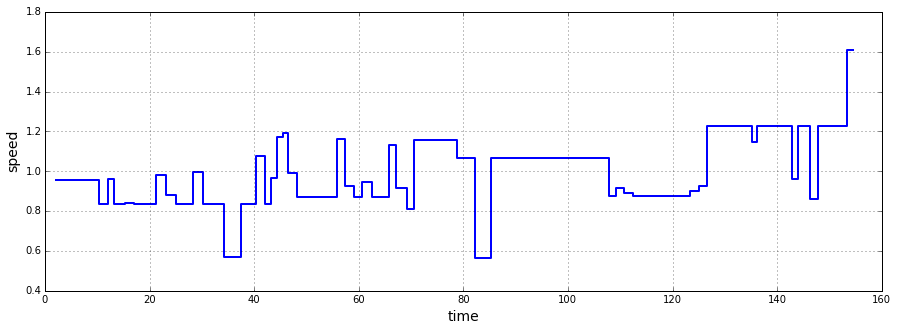

In [5]:
mat_contents = sio.loadmat('veh_sched_data.mat')
speed, time = speed_scheduling(mat_contents, visualize=True)

---

** Problem 3. ** Find the dual problem of the LP in a general form (simplify the dual problem):

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & p^Tx \\
& \text{subject to}
& & Ax \leq b, \\
&&& Cx = d. \\
\end{aligned}
\end{equation*}
$$

### Solution

Let us write down Lagrangian of our problem:

$$
\mathbf{L} = p^Tx + \lambda_1^T (Ax-b) + \lambda_2^T (Cx-d) = (p^T + \lambda_1^TA + \lambda_2^TC)x - (\lambda_1^Tb + \lambda_2^Tc)
$$

Looking at Lagrangian we can easily write down the dual problem:

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{maximize}}
& & - (\lambda_1^Tb + \lambda_2^Tc) \\
& \text{subject to}
& & p^T + \lambda_1^TA + \lambda_2^TC = 0, \\
&&& \lambda_1 \geq 0. \\
\end{aligned}
\end{equation*}
$$

---

** Problem 4. ** Consider the following convex quadratic program:

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & (x_1^2+x_2^2-x_1x_2) \\
& \text{subject to}
& & x_1 + 2x_2 \geq 1, \\
&&& 3x_1 + x_2 \geq 1. \\
\end{aligned}
\end{equation*}
$$

Derive the dual program. Put both programs into CVX and solve them. Verify that the optimal values are the same. State the KKT conditions. Check that the optimal primal and dual variables satisfy them.

### Solution

Let us rewrite our problem in matrix form:

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \frac{1}{2}x^TAx \\
& \text{subject to}
& & Cx \geq b.
\end{aligned}
\end{equation*}
$$

where $A = \begin{pmatrix} 2 & -1 \\ -1 & 2 \end{pmatrix},\;С = \begin{pmatrix} 1 & 2 \\ 3 & 1 \end{pmatrix},\;b = \begin{pmatrix} 1 \\ 1 \end{pmatrix},\;x=\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}.$

Lagrangian of this problem is

$$
\mathbf{L} = \frac{1}{2}x^TAx + \lambda^T (b-Cx), \\
\frac{\partial\mathbf{L}}{\partial x} = x^TA -\lambda^TC = 0 \Rightarrow x = (A^{-1})^TC^T\lambda, \\
\mathbf{L} = \frac{1}{2}\lambda^TCA^{-1}Ax + \lambda^T (b-Cx) = -\frac{1}{2}\lambda^TCx + \lambda^Tb = -\frac{1}{2}\lambda^T(CA^{-1}C^T)\lambda + \lambda^Tb.
$$

The dual problem is:

$$
\begin{equation*}
\begin{aligned}
& \underset{\lambda}{\text{maximize}}
& & -\frac{1}{2}\lambda^T(CA^{-1}C^T)\lambda + \lambda^Tb \\
& \text{subject to}
& & \lambda \geq 0.
\end{aligned}
\end{equation*}
$$

In [6]:
A = np.array([[2, -1], [-1, 2]])
C = np.array([[1, 2], [3, 1]])
b = np.array([[1],[1]])

def primal(A=A, C=C, b=b):
    """Solve primal CQP problem."""
    
    x = cvx.Variable(2)
    constraints = [C*x >= b]
    objective = cvx.Minimize(cvx.quad_form(x,0.5*A))
    prob = cvx.Problem(objective, constraints)
    sol = prob.solve()
    
    return sol, x.value

def dual(A=A, C=C, b=b):
    """Solve dual problem for our QCP problem."""
    
    l = cvx.Variable(2)
    P = 0.5*C.dot(np.linalg.inv(A).dot(C.T))
    constraints = [l >= 0]
    objective = cvx.Maximize(-cvx.quad_form(l, P) + l.T*b)
    prob = cvx.Problem(objective, constraints)
    sol = prob.solve()
    
    return sol, l.value

In [7]:
primal_obj, x = primal()
dual_obj, l = dual()
print "Primal problem optimal value:", primal_obj
print "Dual problem optimal value:", dual_obj

Primal problem optimal value: 0.107142857081
Dual problem optimal value: 0.107142857825


Karush-Kuhn-Tucker conditions for this problem:

$$
\begin{cases}
Cx^* \geq b,\;\text{(primal feasibility)}\\
\lambda^* \geq 0,\;\text{(dual feasibility)}\\
x^{*T}A - \lambda^{*T}C = 0,\;\text{(vanishing gradient)}\\
\lambda_i^{*}(b-Cx)_i=0,\;i=1,2.\;\text{(complementary slackness)}
\end{cases}
$$

In [8]:
eps = 1e-10
print "Primal feasibility:", (C.dot(x)+eps >= b).min()
print "Dual feasibility:", (l+eps >= 0).min()
print "Vanishing gradient:", (x.T.dot(A) - l.T.dot(C))
print "Complementary slackness", l[0]*(b-C.dot(x))[0], l[1]*(b-C.dot(x))[1]

Primal feasibility: True
Dual feasibility: True
Vanishing gradient: [[ -1.86910457e-06  -2.41874104e-06]]
Complementary slackness [[  8.80158829e-13]] [[ -2.52107566e-10]]


As we see, optimal primal and dual variables satisfy KKT conditions accurate to machine epsilon.

---

** Problem 5. ** Consider the binary linear program:

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & c^Tx \\
& \text{subject to}
& & Ax \leq b, \\
&&& x_i \in \left\{0,1\right\},\;\forall i.
\end{aligned}
\end{equation*}
$$

**(a) (1 point)**  – using partial dualization, dualize the first set of constraints $Ax \leq b$. Write the partial dual, and suggest how it can be evaluated efficiently.

##### Solution

Let us write down Lagrangian of this problem:

$$
\mathbf{L} = c^Tx + \lambda^T(Ax-b) = (c^T + \lambda^TA)x - \lambda^Tb
$$

To minimize Lagrangian with respect to $x$ we should set $x_i=0$ if corresponding coefficient $(c^T + \lambda^TA)_i $ is greater then zero and set $x_i=1$ otherwise. Then the dual problem will look like:

$$
\begin{equation*}
\begin{aligned}
& \underset{\lambda}{\text{maximize}}
& & \sum_{i=1}^n ((c^T + \lambda^TA)_i)_- - \lambda^Tb\\
& \text{subject to}
& & \lambda \geq 0. \\
\end{aligned}
\end{equation*}
$$

where $f_- = \min \{f,0\}$.

**(b) (2 points)** – consider the following instance of the problem

$$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & -x_1-2x_2-4x_3-3x_4 \\
& \text{subject to}
& & 10x_1 + 10x_3 + 10x_4 \leq 15, \\
&&& 10x_1 + 10x_2 + 10x_4 \leq 13, \\
&&& x_i \in \left\{0,1\right\},\;\forall i.
\end{aligned}
\end{equation*}
$$

Evaluate the partial dual from part **(a)** on the grid **mgrid(0:0.05:10,0:0.05:10)**; Plot the resulting function using 3d plot (mpl_toolkits.mplot3d, the MATLAB function surf). Rotate the plot and add 2-3 most telling views to the report. Include one of the views that demonstrate whether strong duality holds for your partial dual (explain whether it holds or not). For rotating plot in ipython notebook, turn off matplotlib inline, so that the plot will be in a separate window.

##### Solution

In [9]:
c = np.array([-1, -2, -4, -3])
A = np.array([[10, 0, 10, 10], [10, 10, 0, 10]])
b = np.array([[15], [13]])
f = []

for l1 in np.arange(0, 10, 0.05):
    for l2 in np.arange(0, 10, 0.05):
        f.append(np.minimum(c+np.array([l1, l2]).dot(A),0).sum() - l1*b[0] - l2*b[1])
        
lam = np.meshgrid(np.arange(0, 10, 0.05), np.arange(0, 10, 0.05))
func = np.array(f).reshape((200, 200))

In [10]:
def gurobi_solve():

    m = grb.Model("BLP")
    m.setParam('OutputFlag', False)

    x = []
    for i in xrange(4):
            x.append(m.addVar(vtype=grb.GRB.BINARY))

    # the objective is to minimize c^Tx
    m.modelSense = grb.GRB.MINIMIZE

    # update model to integrate new variables
    m.update()

    # set optimization objective
    obj_summands = []
    for i in xrange(4):
            obj_summands.append(c[i]*x[i])
    m.setObjective(grb.quicksum(obj_summands)) 

    # set constraints
    for i in xrange(2):
        constr_summands = [A[i][j]*x[j] for j in xrange(4)]
        m.addConstr(sum(constr_summands), grb.GRB.LESS_EQUAL, b[i])

    # find optimal solution
    m.optimize()

    return m.ObjVal

In [11]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(lam[0], lam[1], func)
ax.set_xlabel('l1')
ax.set_ylabel('l2')
ax.set_zlabel('obj')
fig.show()

<img src="figure_1.png">
<img src="figure_2.png">
<img src="figure_3.png">

In [12]:
print "Optimal objective from plot:", func.max()
print "Real otimal objective:", gurobi_solve()

Optimal objective from plot: -7.1
Real otimal objective: -6.0


As optimal objective from plot is less than the real one, strong duality doesn't hold for our partial dual.